<a href="https://colab.research.google.com/github/lijin-durairaj-code-mode/codes/blob/main/insurance_premium_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## installing required libraries

In [ ]:
# !pip install xgboost
# !pip install optuna

## importing libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math


#sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#metrics
from sklearn.metrics import mean_squared_error


import xgboost as xgb
import optuna

## configuration setting

In [ ]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

## EDA
##### insight of data
##### handling missing values
##### data visualization
##### outlier detection
##### feature relationship

In [ ]:
_data=pd.read_csv('/content/train.csv')

In [ ]:
_data=_data.sample(15000,random_state=63)

In [ ]:
_data.reset_index(drop=True,inplace=True)

In [ ]:
_data.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,771590,35.0,Female,11052.0,Single,3.0,High School,Self-Employed,4.334468,Urban,Comprehensive,0.0,7.0,NaN,8.0,2022-12-18 15:21:39.228521,Average,No,Daily,Condo,509.0
1,222110,52.0,Female,39042.0,Married,3.0,High School,Employed,23.857121,Urban,Comprehensive,2.0,13.0,751.0,4.0,2022-06-07 15:21:39.271453,Good,No,Rarely,Condo,756.0
2,654545,25.0,Female,36250.0,Single,1.0,Bachelor's,Employed,7.079677,Urban,Basic,3.0,8.0,NaN,8.0,2021-08-02 15:21:39.173661,Poor,No,Daily,Apartment,1459.0
3,92462,42.0,Female,2820.0,Divorced,1.0,Master's,Self-Employed,NaN,Rural,Basic,NaN,6.0,NaN,7.0,2021-10-07 15:21:39.207847,Poor,Yes,Daily,Condo,943.0
4,510142,23.0,Female,3424.0,Married,2.0,PhD,Unemployed,5.753982,Urban,Premium,NaN,0.0,749.0,7.0,2023-04-11 15:21:39.149731,Good,Yes,Weekly,Condo,2266.0


In [ ]:
data_y=_data['Premium Amount']
data_x=_data.drop('Premium Amount',axis=1)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(data_x,data_y,test_size=0.25,random_state=42)

###### 1. converting Policy Start Date to datetime
###### 2. checking the most recent policy date
###### 3. diff the most recent date with the policy to get the num of days

In [ ]:
def convert_psd_days(_d):
  return (
      _d
    .assign(
        policy_active_days=lambda df:(max_date:=pd.to_datetime(df['Policy Start Date']).max())
        and df['Policy Start Date'].apply(
            lambda x:(max_date-pd.to_datetime(x)).days
        )
    )
    .drop(['Policy Start Date','id'],axis=1)
  )

In [ ]:
x_train=convert_psd_days(x_train)

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11250 entries, 7410 to 7270
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   11093 non-null  float64
 1   Gender                11250 non-null  object 
 2   Annual Income         10875 non-null  float64
 3   Marital Status        11092 non-null  object 
 4   Number of Dependents  10222 non-null  float64
 5   Education Level       11250 non-null  object 
 6   Occupation            7884 non-null   object 
 7   Health Score          10578 non-null  float64
 8   Location              11250 non-null  object 
 9   Policy Type           11250 non-null  object 
 10  Previous Claims       7804 non-null   float64
 11  Vehicle Age           11249 non-null  float64
 12  Credit Score          9957 non-null   float64
 13  Insurance Duration    11250 non-null  float64
 14  Customer Feedback     10545 non-null  object 
 15  Smoking Status        

In [ ]:
x_train.describe()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,policy_active_days
count,11093.000000,10875.000000,10222.000000,10578.000000,7804.000000,11249.000000,9957.00000,11250.000000,11250.000000
mean,40.990535,32513.260138,2.012326,25.691267,1.001281,9.634279,592.08828,5.018222,912.689956
std,13.572115,31875.740908,1.413191,12.130029,0.983002,5.752307,149.44124,2.590615,518.687991
min,18.000000,2.000000,0.000000,2.390034,0.000000,0.000000,300.00000,1.000000,0.000000
25%,29.000000,7984.000000,1.000000,16.186311,0.000000,5.000000,469.00000,3.000000,468.000000
50%,41.000000,23648.000000,2.000000,24.723863,1.000000,10.000000,593.00000,5.000000,914.500000
75%,53.000000,44284.000000,3.000000,34.561535,2.000000,15.000000,718.00000,7.000000,1355.000000
max,64.000000,149996.000000,4.000000,55.991279,6.000000,19.000000,849.00000,9.000000,1825.000000


<Axes: xlabel='percentage of null data', ylabel='columns name'>

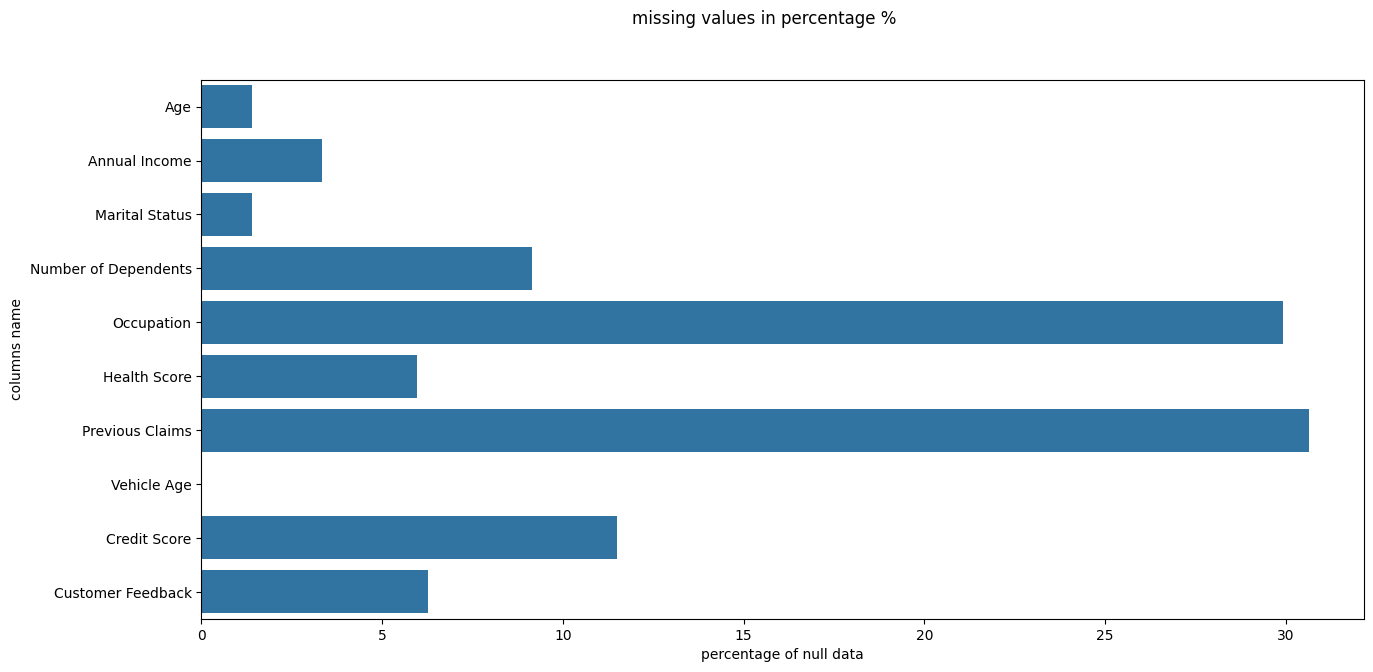

In [ ]:
_null_data=x_train.isnull().sum()[x_train.isnull().sum().values>0]

fig,ax=plt.subplots(1,1,figsize=(15,7))

ax.set_xlabel('percentage of null data')
ax.set_ylabel('columns name')

fig.suptitle('missing values in percentage %')
sns.barplot((_null_data/len(x_train))*100,ax=ax,orient='h')

In [ ]:
categorical_columns=x_train.select_dtypes('object').columns
nunmerical_columns=x_train.select_dtypes(['int64','float64']).columns

###### categorical columns data distribution

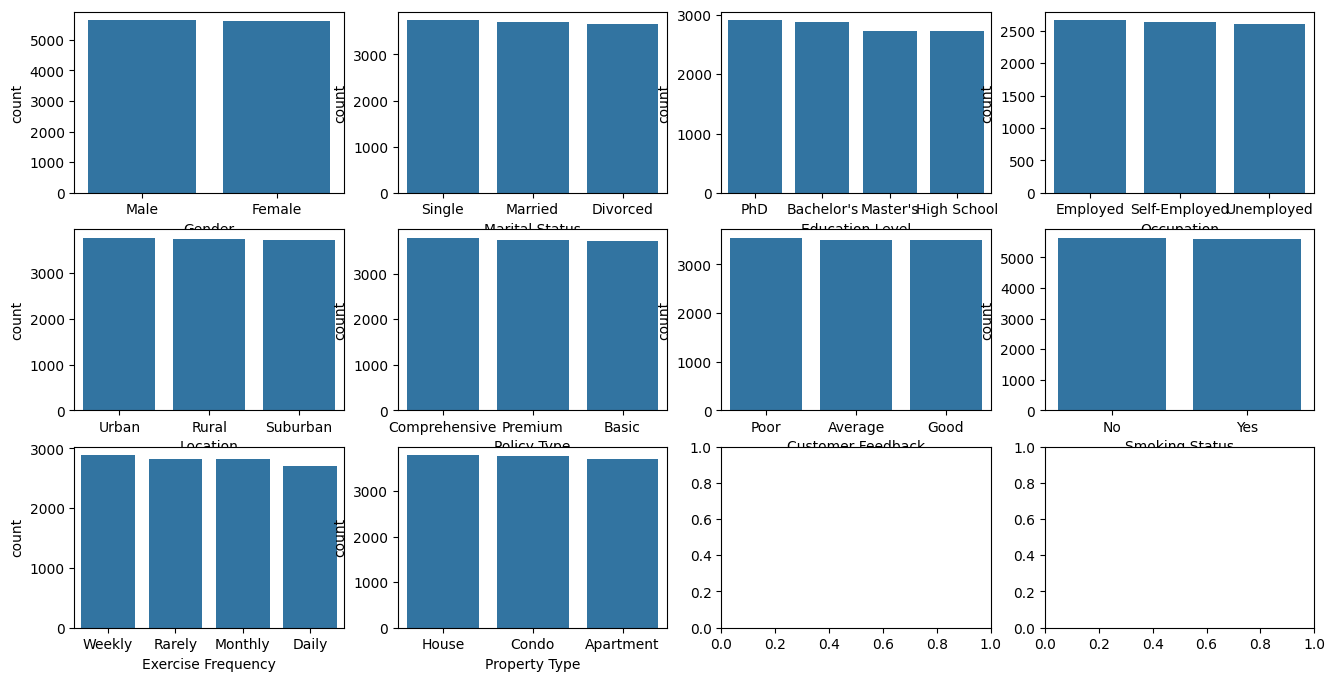

In [ ]:
columns_per_row=4
num_rows=math.ceil(int(len(categorical_columns))/columns_per_row)
fig,ax=plt.subplots(num_rows,columns_per_row,figsize=(16,8))
total_cat_columns=len(categorical_columns)-1
counter=0

for col in range(num_rows):
  for row in range(columns_per_row):
    if not counter>total_cat_columns:
      sns.barplot(x_train[categorical_columns[counter]].value_counts(),ax=ax[col,row])
      counter+=1

<ipython-input-295-86e69e4bd1f0>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_train[nunmerical_columns[counter]],ax=ax[col,row])
<ipython-input-295-86e69e4bd1f0>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_train[nunmerical_columns[counter]],ax=ax[col,row])
<ipython-input-295-86e69

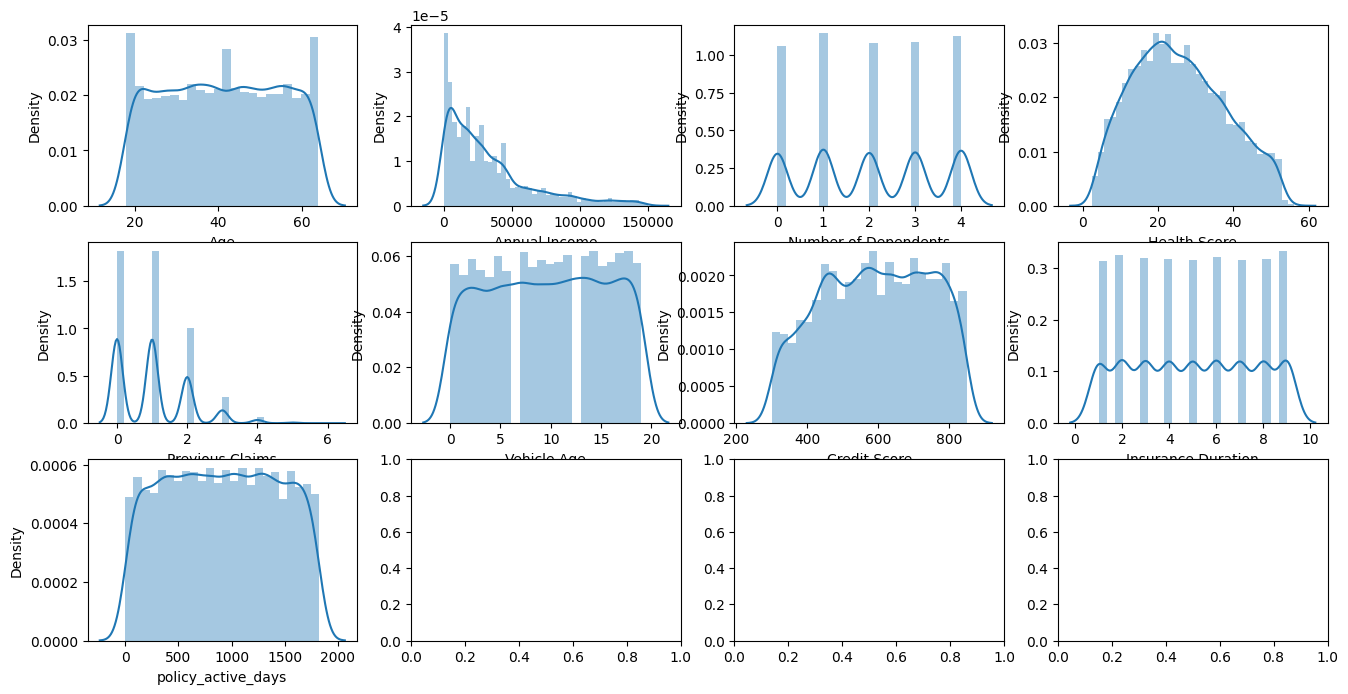

In [ ]:
columns_per_row=4
num_rows=math.ceil(int(len(nunmerical_columns))/columns_per_row)
fig,ax=plt.subplots(num_rows,columns_per_row,figsize=(16,8))
total_cat_columns=len(nunmerical_columns)-1
counter=0

for col in range(num_rows):
  for row in range(columns_per_row):
    if not counter>total_cat_columns:
      sns.distplot(x_train[nunmerical_columns[counter]],ax=ax[col,row])
      counter+=1

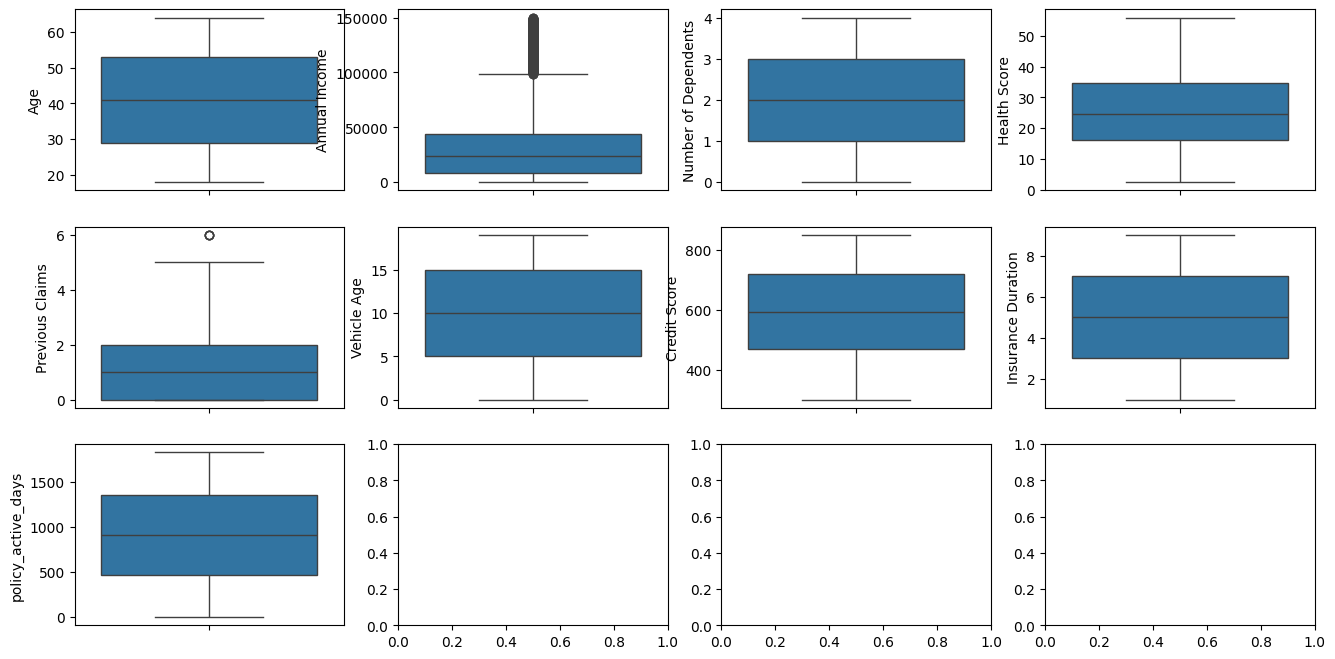

In [ ]:
columns_per_row=4
num_rows=math.ceil(int(len(nunmerical_columns))/columns_per_row)
fig,ax=plt.subplots(num_rows,columns_per_row,figsize=(16,8))
total_cat_columns=len(nunmerical_columns)-1
counter=0

for col in range(num_rows):
  for row in range(columns_per_row):
    if not counter>total_cat_columns:
      sns.boxplot(x_train[nunmerical_columns[counter]],ax=ax[col,row])
      counter+=1

## data processing
##### handling missing values
##### handling outliers
##### feature scaling


In [ ]:
for null_columns in _null_data.index:
  null_percentage=(x_train[null_columns].isnull().sum()/len(_data))*100
  print(f'column name: {null_columns}')
  print(f'percentage of null: {round(null_percentage,2)}%')
  print(x_train[null_columns].unique())
  print('---------------------------------------')



column name: Age
percentage of null: 1.05%
[56. 51. 59. 21. 40. 30. 43. 18. 42. 20. 55. 63. 24. 64. 48. 36. 27. 28.
 44. 60. 33. 46. 34. 23. nan 29. 52. 39. 38. 49. 35. 25. 50. 26. 32. 58.
 47. 53. 37. 22. 19. 31. 57. 45. 54. 61. 62. 41.]
---------------------------------------
column name: Annual Income
percentage of null: 2.5%
[37876. 20290. 38720. ... 62842. 81712. 76783.]
---------------------------------------
column name: Marital Status
percentage of null: 1.05%
['Married' 'Single' 'Divorced' nan]
---------------------------------------
column name: Number of Dependents
percentage of null: 6.85%
[ 4.  1.  0.  3.  2. nan]
---------------------------------------
column name: Occupation
percentage of null: 22.44%
['Unemployed' 'Self-Employed' 'Employed' nan]
---------------------------------------
column name: Health Score
percentage of null: 4.48%
[19.83341251  6.94826524 10.28984336 ... 48.07156727 21.73921738
 28.96664885]
---------------------------------------
column name: Prev

In [ ]:
#removing Occupation & Previous Claims as this has more missing values
def dropping_high_missingvalue_col(_d):
  _d.drop(['Occupation','Previous Claims'],axis=1,inplace=True)
  return _d


x_train=dropping_high_missingvalue_col(x_train)

In [ ]:
x_train.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Health Score,Location,Policy Type,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,policy_active_days
7410,56.0,Female,37876.0,Married,4.0,High School,19.833413,Urban,Comprehensive,16.0,499.0,2.0,Poor,Yes,Weekly,Condo,315
10894,51.0,Male,20290.0,Married,1.0,Bachelor's,6.948265,Rural,Basic,18.0,NaN,1.0,Poor,No,Weekly,House,381
1934,59.0,Male,38720.0,Married,0.0,PhD,10.289843,Urban,Basic,18.0,778.0,3.0,Average,Yes,Monthly,Condo,751
11539,21.0,Male,28699.0,Married,4.0,PhD,25.859761,Rural,Comprehensive,17.0,810.0,5.0,Average,Yes,Weekly,Condo,727
2952,40.0,Female,23003.0,Married,3.0,Master's,19.555933,Rural,Basic,15.0,657.0,8.0,Poor,No,Rarely,Condo,1278


In [ ]:
obj_col=x_train.select_dtypes('object').columns
num_col=x_train.select_dtypes(['int64','float64']).columns

In [ ]:
def process_data():
  cat_pipe=Pipeline([
                  ('impute',SimpleImputer(strategy='most_frequent')),
                  ('encode',OneHotEncoder(drop='first',handle_unknown='ignore'))
  ])

  num_pipe=Pipeline([
                  ('impute',SimpleImputer(strategy='mean')),
                  ('scaling',StandardScaler())

  ])

  ct=ColumnTransformer([
                    ('num',num_pipe,num_col),
                      ('cat',cat_pipe,obj_col)

  ],remainder='passthrough')

  return Pipeline([
                          ('trans',ct),
                          ('mdl','passthrough')
  ])

  # _processed_data=_grand_processing.fit_transform(_d)
  # return _processed_data, _grand_processing


In [ ]:
processing_pipeline=process_data()

In [ ]:
x_train_processed=processing_pipeline.fit_transform(x_train)

In [ ]:
x_train_processed.shape

(11250, 26)

##### test data

In [ ]:
x_test=convert_psd_days(x_test)

In [ ]:
x_test=dropping_high_missingvalue_col(x_test)

In [ ]:
x_test_processed=processing_pipeline.transform(x_test)

In [ ]:
x_test_processed.shape

(3750, 26)

## feature engineering
##### feature selection
##### feature extraction
##### feature creation

## model selection & training

In [ ]:
scaler = StandardScaler()
y_train_scaled=scaler.fit_transform(y_train.to_numpy().reshape(-1,1))
y_test_scaled=scaler.transform(y_test.to_numpy().reshape(-1,1))

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-5, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-5, 1.0, log=True),
    }

    model = xgb.XGBRegressor(**params, objective="reg:squarederror", random_state=42)
    model.fit(x_train_processed, y_train_scaled, eval_set=[(x_test_processed, y_test_scaled)], verbose=False)

    # Predict and calculate RMSE
    preds = model.predict(x_test_processed)
    rmse = mean_squared_error(y_test_scaled, preds)

    return rmse  # Optuna minimizes RMSE

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

[I 2025-03-03 11:28:35,502] A new study created in memory with name: no-name-7e64b9a8-9299-4277-9d41-5b1913b839df
[I 2025-03-03 11:28:40,428] Trial 0 finished with value: 1.0629515059630859 and parameters: {'n_estimators': 950, 'learning_rate': 0.1113386008287723, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6832968521159464, 'colsample_bytree': 0.8086245359871448, 'reg_alpha': 7.459199756962298e-05, 'reg_lambda': 0.3015961486355176}. Best is trial 0 with value: 1.0629515059630859.
[I 2025-03-03 11:28:41,663] Trial 1 finished with value: 1.0188049798460492 and parameters: {'n_estimators': 450, 'learning_rate': 0.07680514419596689, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.7435822302037611, 'colsample_bytree': 0.8743394341907891, 'reg_alpha': 0.0001513255423846231, 'reg_lambda': 0.000339189144178505}. Best is trial 1 with value: 1.0188049798460492.
[I 2025-03-03 11:28:48,723] Trial 2 finished with value: 1.0376429846275084 and parameters: {'n_estimators': 700, 'lear

In [ ]:
study.best_params

{'n_estimators': 550,
 'learning_rate': 0.030074707059211746,
 'max_depth': 5,
 'min_child_weight': 5,
 'subsample': 0.7786822293713013,
 'colsample_bytree': 0.7752370938110639,
 'reg_alpha': 0.0002502940739358686,
 'reg_lambda': 0.05277842603278668}

In [ ]:
study.best_value

749127.2590137195

In [ ]:
model = xgb.XGBRegressor(**study.best_params, objective="reg:squarederror", random_state=42)
model.fit(x_train_processed, y_train_scaled, eval_set=[(x_test_processed, y_test_scaled)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7752370938110639, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.030074707059211746, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=550, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred=model.predict(x_test_processed)
rmse=mean_squared_error(y_test_scaled,y_pred)

In [ ]:
rmse

1.0141957626360218

In [ ]:
y_pred

array([-0.30503523, -0.14985734, -0.00526692, ..., -0.08789206,
       -0.04795713, -0.2918141 ], dtype=float32)

In [ ]:
scaler.inverse_transform(y_pred.reshape(-1,1))

array([[ 845.4346 ],
       [ 979.4594 ],
       [1104.34   ],
       ...,
       [1032.9779 ],
       [1067.4691 ],
       [ 856.85345]], dtype=float32)

## data analysis

In [ ]:
x_test_processed[0]

array([ 0.89114315,  1.60587404, -0.7515351 , -0.57633148,  1.45445396,
       -0.28515486, -0.00703425,  0.20882469,  1.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ])

In [ ]:
x_train_processed[0]

array([ 1.11375334,  0.17112286,  1.47561753, -0.49804859,  1.10673644,
       -0.66215301, -1.16511185, -1.15236237,  0.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ])

## hyper parameter tuning

## interpreting results

range(0, 10)

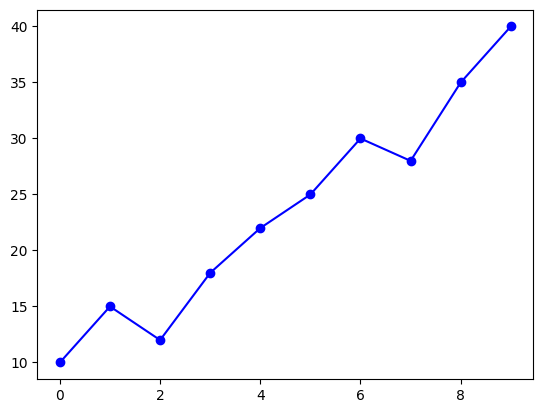

In [ ]:
# x = range(0, len(y_test))
# sns.lineplot(y_test)
# plt.plot(range(1,len(y_test)),y_test)
x = range(0, 10)
actual = [10, 15, 12, 18, 22, 25, 30, 28, 35, 40]
plt.plot(x, actual, marker="o", linestyle="-", color="blue", label="Actual")
x